## Mini-batch model for hpc run with input edge weights in csv file

Comments:

By using the read weighted edge list from a csv file, it saves much space on self.graph

This will for specific batch number and hop-layer number

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import copy
import csv
import os
import sys
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
import pickle
import shutil

from utils import *


In [3]:
import inspect
import torch
from torch_geometric.utils import scatter_

special_args = [
    'edge_index', 'edge_index_i', 'edge_index_j', 'size', 'size_i', 'size_j'
]
__size_error_msg__ = ('All tensors which should get mapped to the same source '
                      'or target nodes must be of same size in dimension 0.')

is_python2 = sys.version_info[0] < 3
getargspec = inspect.getargspec if is_python2 else inspect.getfullargspec


class MessagePassing(torch.nn.Module):
    r"""Base class for creating message passing layers

    .. math::
        \mathbf{x}_i^{\prime} = \gamma_{\mathbf{\Theta}} \left( \mathbf{x}_i,
        \square_{j \in \mathcal{N}(i)} \, \phi_{\mathbf{\Theta}}
        \left(\mathbf{x}_i, \mathbf{x}_j,\mathbf{e}_{i,j}\right) \right),

    where :math:`\square` denotes a differentiable, permutation invariant
    function, *e.g.*, sum, mean or max, and :math:`\gamma_{\mathbf{\Theta}}`
    and :math:`\phi_{\mathbf{\Theta}}` denote differentiable functions such as
    MLPs.
    See `here <https://pytorch-geometric.readthedocs.io/en/latest/notes/
    create_gnn.html>`__ for the accompanying tutorial.

    Args:
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"` or :obj:`"max"`).
            (default: :obj:`"add"`)
        flow (string, optional): The flow direction of message passing
            (:obj:`"source_to_target"` or :obj:`"target_to_source"`).
            (default: :obj:`"source_to_target"`)
    """

    def __init__(self, aggr='add', flow='source_to_target'):
        super(MessagePassing, self).__init__()

        self.aggr = aggr
        assert self.aggr in ['add', 'mean', 'max']

        self.flow = flow
        # give a warning if the option is not valid
        assert self.flow in ['source_to_target', 'target_to_source']

        self.__message_args__ = getargspec(self.message)[0][1:]
        # we will have [x_j, norm ] put into self.__message_args__
        
        self.__special_args__ = [(i, arg)
                                 for i, arg in enumerate(self.__message_args__)
                                 if arg in special_args]
        
        self.__message_args__ = [arg for arg in self.__message_args__ if arg not in special_args]
        
        self.__update_args__ = getargspec(self.update)[0][2:]
        # empty, since there is nothing beyond: agg_out

#     function call: res = self.propagate(edge_index, x=x, norm=norm)
    def propagate(self, edge_index, size=None, **kwargs):
        r"""The initial call to start propagating messages.

        Args:
            edge_index (Tensor): The indices of a general (sparse) assignment
                matrix with shape :obj:`[N, M]` (can be directed or
                undirected).
            size (list or tuple, optional): The size :obj:`[N, M]` of the
                assignment matrix. If set to :obj:`None`, the size is tried to
                get automatically inferred. (default: :obj:`None`)
            **kwargs: Any additional data which is needed to construct messages
                and to update node embeddings.
        """
        dim = 0
        size = [None, None] if size is None else list(size)
        assert len(size) == 2

        i, j = (0, 1) if self.flow == 'target_to_source' else (1, 0)
        # here (i, j) == (1, 0)
        ij = {"_i": i, "_j": j}

        message_args = []
        
        for arg in self.__message_args__:
#             arg[-2] == '_j'
            if arg[-2:] in ij.keys():
#                 tmp == x, is inside the dwargs
                tmp = kwargs.get(arg[:-2], None)   # get the value of the parameter
                if tmp is None:  # pragma: no cover
                    message_args.append(tmp)
                else:
                    idx = ij[arg[-2:]]    # idx == 0
                    if isinstance(tmp, tuple) or isinstance(tmp, list):
                        assert len(tmp) == 2
                        if tmp[1 - idx] is not None:
                            if size[1 - idx] is None:
                                size[1 - idx] = tmp[1 - idx].size(dim)
                            if size[1 - idx] != tmp[1 - idx].size(dim):
                                raise ValueError(__size_error_msg__)
                        tmp = tmp[idx]
                    
                    if tmp is None:
                        message_args.append(tmp)
                    else:
                        if size[idx] is None:
                            size[idx] = tmp.size(dim)
                        if size[idx] != tmp.size(dim):
                            raise ValueError(__size_error_msg__)
                        # dim == 0, we duplicate part of the embeddings x by using the edge_index[idx]
#                         print('Inside the propagate, edge_index[idx]: \n', edge_index[idx].shape, '\n', edge_index[idx])
                        tmp = torch.index_select(tmp, dim, edge_index[idx])
                        message_args.append(tmp)   # here we append x from the kwargs
            else:
                message_args.append(kwargs.get(arg, None))   # here we append norm
        
#         message_args are: x_j, norm 
#         size:  [8, None] 
#         kwargs:  dict_keys(['x', 'norm']) 
#         special keys:  []
        
        size[0] = size[1] if size[0] is None else size[0]
        size[1] = size[0] if size[1] is None else size[1]

        kwargs['edge_index'] = edge_index
        kwargs['size'] = size
        
        # for now self.__special_args__ is empty
        for (idx, arg) in self.__special_args__:
            if arg[-2:] in ij.keys():
                # here we will change the content of x (features)
                # features will be corresponds to edge_index
                message_args.insert(idx, kwargs[arg[:-2]][ij[arg[-2:]]])
            else:
                message_args.insert(idx, kwargs[arg])

        update_args = [kwargs[arg] for arg in self.__update_args__]
#         message_args are: x_j, norm 
        out = self.message(*message_args)
        # here i = 1, edge_index is the target endpoint of an edge, size[i] is the size of target endpoints
        out = scatter_(self.aggr, out, edge_index[i], dim_size=size[i])
        out = self.update(out, *update_args)
        return out

    def message(self, x_j):  # pragma: no cover
        r"""Constructs messages in analogy to :math:`\phi_{\mathbf{\Theta}}`
        for each edge in :math:`(i,j) \in \mathcal{E}`.
        Can take any argument which was initially passed to :meth:`propagate`.
        In addition, features can be lifted to the source node :math:`i` and
        target node :math:`j` by appending :obj:`_i` or :obj:`_j` to the
        variable name, *.e.g.* :obj:`x_i` and :obj:`x_j`."""

        return x_j

    def update(self, aggr_out):  # pragma: no cover
        r"""Updates node embeddings in analogy to
        :math:`\gamma_{\mathbf{\Theta}}` for each node
        :math:`i \in \mathcal{V}`.
        Takes in the output of aggregation as first argument and any argument
        which was initially passed to :meth:`propagate`."""

        return aggr_out


In [4]:
import math
import random

from torch.nn import Parameter
from torch_scatter import scatter_add
# from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_remaining_self_loops

### ================== Definition of custom GCN

def glorot(tensor):
    if tensor is not None:
        stdv = math.sqrt(6.0 / (tensor.size(-2) + tensor.size(-1)))
        tensor.data.uniform_(-stdv, stdv)
#         tensor.data.fill_(1.0)   # trivial example
        
def zeros(tensor):
    if tensor is not None:
        tensor.data.fill_(0)

class custom_GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, improved=False, cached=False,
                 bias=True, **kwargs):
        super().__init__(aggr='add', **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached

        self.weight = Parameter(torch.Tensor(in_channels, out_channels))

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        zeros(self.bias)
        self.cached_result = None
        self.cached_num_edges = None


    @staticmethod
    def norm(edge_index, num_nodes, edge_weight=None, improved=False, dtype=None):
        
        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype, device=edge_index.device)
        
        fill_value = 1 if not improved else 2
        
        edge_index, edge_weight = add_remaining_self_loops(
            edge_index, edge_weight, fill_value, num_nodes)
        
        row, col = edge_index   
        # row includes the starting points of the edges  (first row of edge_index)
        # col includes the ending points of the edges   (second row of edge_index)

        deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)
        # row records the source nodes, which is the index we are trying to add
        # deg will record the out-degree of each node of x_i in all edges (x_i, x_j) including self_loops
        
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        normalized_edge_weight = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        
#         print('whole GCN training normalized_edge_weight: \n', normalized_edge_weight)
        return edge_index, normalized_edge_weight

    def forward(self, x, edge_index, edge_weight = None):
        """"""
#         print('current weight is: ')
#         print(self.weight)
#         print('current bias is: ')
#         print(self.bias)
        
        x = torch.matmul(x, self.weight)   # update x (embeddings)
        
#         print('inside custom_GCN, edge_index: ', edge_index.shape, '\n', edge_index)
        res = self.propagate(edge_index, x = x, norm = edge_weight)
        return res

    # self is the first parameter of the message func
    def message(self, x_j, norm):
        # in source code of the MessagePassing:
#         self.__message_args__ = getargspec(self.message)[0][1:]  : will be initialized as [x_j, norm]
        
        # view is to reshape the tensor, here make it only a single column
        # use the normalized weights multiplied by the feature of the target nodes
        '''
        For each of extended edge_index:(x_i, x_j), assume there is N such edges
        x_j of shape (N, k) , assume there is k features, value along each row are the same
        norm of shape (1, m), assume there is m edges (including self loops), 1-D tensor
        '''
#         print('inside the message custom_GCN: norm \n', norm.shape, '\n', norm)
#         print('inside the message custom_GCN: x_j \n', x_j.shape, '\n', x_j)
        res = norm.view(-1, 1) * x_j  # use the element wise multiplication
        return res

    def update(self, aggr_out):
        # update the embeddings of each node
        if self.bias is not None:
            aggr_out = aggr_out + self.bias
        return aggr_out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)



In [5]:
### ====================== Establish a GCN based model ========================
class ListModule(torch.nn.Module):
    """
    Abstract list layer class.
    """
    def __init__(self, *args):
        """
        Module initializing.
        """
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        """
        Getting the indexed layer.
        """
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        """
        Iterating on the layers.
        """
        return iter(self._modules.values())

    def __len__(self):
        """
        Number of layers.
        """
        return len(self._modules)


class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, input_layers = [16, 16], dropout=0.3):
        """
        input layers: list of integers
        dropout: probability of droping out 
        """
        super(Net, self).__init__()
        # one trivial example
#         self.conv1 = custom_GCNConv(in_channels, out_channels)
#         self.conv2 = GCNConv(16, dataset.num_classes)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_layers = input_layers
        self.dropout = dropout
        self.setup_layers()

    def setup_layers(self):
        """
        Creating the layes based on the args.
        """
        self.layers = []
        self.input_layers = [self.in_channels] + self.input_layers + [self.out_channels]
        for i, _ in enumerate(self.input_layers[:-1]):
            self.layers.append(custom_GCNConv(self.input_layers[i],self.input_layers[i+1]))
        self.layers = ListModule(*self.layers)

    # change the dropout positions: 
    def forward(self, edge_index, features, edge_weights = None):
        if len(self.layers) > 1:
            for i in range(len(self.layers)-1):
                features = F.relu(self.layers[i](features, edge_index, edge_weights))
#                 if i>0:
                features = F.dropout(features, p = self.dropout, training = self.training)
                    
            features = self.layers[len(self.layers)-1](features, edge_index, edge_weights)
        else:
            features = self.layers[0](features, edge_index, edge_weights)    # for a single layer case

        predictions = F.log_softmax(features, dim=1)
        return predictions

### Utility functions

In [6]:
def get_edge_weight(edge_index, num_nodes, edge_weight=None, improved=False, dtype=None, store_path='./tmp/'):
    """
        edge_index(ndarray): undirected edge index (two-directions both included)
        num_nodes(int):  number of nodes inside the graph
        edge_weight(ndarray): if any weights already assigned, otherwise will be generated 
        improved(boolean):   may assign 2 to the self loop weight if true
        store_path(string): the path of the folder to contain all the clustering information files
    """
    # calculate the global graph properties, global edge weights
    if edge_weight is None:
        edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype, device=edge_index.device)

    fill_value = 1 if not improved else 2
    # there are num_nodes self-loop edges added after the edge_index
    edge_index, edge_weight = add_remaining_self_loops(edge_index, edge_weight, fill_value, num_nodes)

    row, col = edge_index   
    # row includes the starting points of the edges  (first row of edge_index)
    # col includes the ending points of the edges   (second row of edge_index)

    deg = scatter_add(edge_weight, row, dim=0, dim_size=num_nodes)
    # row records the source nodes, which is the index we are trying to add
    # deg will record the out-degree of each node of x_i in all edges (x_i, x_j) including self_loops

    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    # normalize the edge weight
    normalized_edge_weight = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

    # transfer from tensor to the numpy to construct the dict for the edge_weights
    edge_index = edge_index.t().numpy()
    normalized_edge_weight = normalized_edge_weight.numpy()

    num_edge = edge_index.shape[0]

    output = ([edge_index[i][0], edge_index[i][1], normalized_edge_weight[i]] for i in range(num_edge))

    # output the edge weights as the csv file
    input_edge_weight_txt_file = store_path + 'input_edge_weight_list.csv'
    os.makedirs(os.path.dirname(input_edge_weight_txt_file), exist_ok=True)
    with open(input_edge_weight_txt_file, 'w', newline='\n') as fp:
        wr = csv.writer(fp, delimiter = ' ')
        for line in output:
            wr.writerow(line)
    return input_edge_weight_txt_file

### Partition GCN

#### Partition method

In [7]:

import metis
import random
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from itertools import chain

class ClusteringMachine(object):
    """
    Clustering the graph, feature set and label. Performed on the CPU side
    """
    def __init__(self, edge_index, features, label, tmp_folder = './tmp/'):
        """
        :param edge_index: COO format of the edge indices.
        :param features: Feature matrix (ndarray).
        :param label: label vector (ndarray).
        :tmp_folder(string): the path of the folder to contain all the clustering information files
        """
        self.features = features
        self.label = label
        self._set_sizes()
        self.edge_index = edge_index
        # store the information folder for memory tracing
        self.tmp_folder = tmp_folder
        
        edge_weight_file = self.tmp_folder + 'input_edge_weight_list.csv'
        self.graph = nx.read_weighted_edgelist(edge_weight_file, create_using = nx.Graph, nodetype = int)

    def _set_sizes(self):
        """
        Setting the feature and class count.
        """
        self.node_count = self.features.shape[0]
        self.feature_count = self.features.shape[1]    # features all always in the columns
        self.label_count = len(np.unique(self.label.numpy()) )
    
    # 2) first assign train, test, validation nodes, split edges; this is based on the assumption that the clustering is no longer that important
    def split_whole_nodes_edges_then_cluster(self, test_ratio, validation_ratio, train_batch_num = 2, valid_batch_num = 2, test_batch_num = 2):
        """
            Only split nodes
            First create train-test splits, then split train and validation into different batch seeds
            Input:  
                1) ratio of test, validation
                2) partition number of train nodes, test nodes, validation nodes
            Output:
                1) self.sg_validation_nodes_global, self.sg_train_nodes_global, self.sg_test_nodes_global
        """
        relative_test_ratio = (test_ratio) / (1 - validation_ratio)
        
        # first divide the nodes for the whole graph, result will always be a list of lists 
        model_nodes_global, valid_nodes_global = train_test_split(list(self.graph.nodes()), test_size = validation_ratio)
        train_nodes_global, test_nodes_global = train_test_split(model_nodes_global, test_size = relative_test_ratio)
        
#         self.sg_train_nodes_global = self.random_clustering(train_nodes_global, train_batch_num)
#         self.sg_validation_nodes_global = self.random_clustering(valid_nodes_global, valid_batch_num)
#         self.sg_test_nodes_global = self.random_clustering(test_nodes_global, test_batch_num)

        self.sg_train_nodes_global = self.metis_clustering(train_nodes_global, train_batch_num)
        self.sg_validation_nodes_global = self.metis_clustering(valid_nodes_global, valid_batch_num)
        self.sg_test_nodes_global = self.metis_clustering(test_nodes_global, test_batch_num)
        
    # just allocate each node to arandom cluster, store the membership inside each dict
    def random_clustering(self, target_nodes, partition_num):
        """
            Random clustering the nodes.
            Input: 
                1) target_nodes: list of node 
                2) partition_num: number of partition to be generated
            Output: 
                1) membership of each node
        """
        # randomly divide into two clusters
        nodes_order = [node for node in target_nodes]
        random.shuffle(nodes_order)
        n = (len(nodes_order) + partition_num - 1) // partition_num
        partition_list = [nodes_order[i * n:(i + 1) * n] for i in range(partition_num)]
#         cluster_membership = {node : i for i, node_list in enumerate(partition_list) for node in node_list}
        cluster_nodes_global = {i : node_list for i, node_list in enumerate(partition_list)}
        
        return cluster_nodes_global

    def metis_clustering(self, target_nodes, partition_num):
        """
            Random clustering the nodes.
            Input: 
                1) target_nodes: list of node 
                2) partition_num: number of partition to be generated
            Output: 
                1) membership of each node
        """
        target_graph = self.graph.subgraph(target_nodes)
        (st, parts) = metis.part_graph(target_graph, partition_num)
        clusters = list(set(parts))
        cluster_nodes_global = defaultdict(list)
        for node, cluster_id in enumerate(parts):
            cluster_nodes_global[cluster_id].append(node)
        return cluster_nodes_global
        
    # select the training nodes as the mini-batch for each cluster
    def mini_batch_sample(self, target_seed, k, frac = 1):
        """
            This function is to generate the neighbors of the seed (either train nodes or validation nodes)
            params: cluster index, number of layer k, fraction of sampling from each neighbor layer
            input: 
                1) target_seed: this is the 0 layer inside self.neighbor
            output:
                1) neighbor: nodes global idx inside each layer of the batch
                2) accum_neighbor: accumulating neighbors , i.e. the final batch nodes
        """
        accum_neighbor = defaultdict(set)
        for cluster in target_seed.keys():
            neighbor = set(target_seed[cluster])  # first layer of the neighbor nodes of each cluster
            for layer in range(k):
                # first accumulate last layer
                accum_neighbor[cluster] |= neighbor
                tmp_level = set()
                for node in neighbor:
                    tmp_level |= set(self.graph.neighbors(node))  # the key here we are using self.graph, extract neighbor from the whole graph
                # add the new layer of neighbors
                tmp_level -= accum_neighbor[cluster]
                # each layer will only contains partial nodes from the previous layer
                neighbor = set(random.sample(tmp_level, int(len(tmp_level) * frac) ) ) if 0 < frac < 1 else tmp_level
    #                 print('layer ' + str(layer + 1) + ' : ', self.neighbor[cluster][layer+1])
            # the most outside layer: kth layer will be added:
            accum_neighbor[cluster] |= neighbor
        return accum_neighbor
        
    def mini_batch_generate(self, batch_file_folder, target_seed, k, fraction = 1.0, batch_range = (0, 1)):
        """
            create the mini-batch focused on the train nodes only, include a total of k layers of neighbors of the original training nodes
            k: number of layers of neighbors for each training node
            fraction: fraction of neighbor nodes in each layer to be considered
            Input:
                1) target_seed: global ids of the nodes for seed to generate the batch
                    usually one of (train_global, test_global_, validation_global)
            Output: all tensors which are gonna be used in the train, forward procedure
                local:
                    1) sg_mini_edges_local
                    2) self.sg_mini_train_edge_weight_local
                    3) self.sg_mini_train_nodes_local
                    4) self.sg_mini_train_features
                    5) self.sg_mini_train_labels
            
        """
        # these are currently believed to be the main memory cost, storing all overlapping batch information
        # instead we store all the information inside one list to be stored in a pickle file as out-of-core mini-batch
        
        # this will get the edge weights in a complete graph
        
        info_batch_node_size = {}
        info_batch_edge_size = {}
                
        accum_neighbor = self.mini_batch_sample(target_seed, k, frac = fraction)
        batch_start, batch_end = batch_range
        for cluster in range(batch_start, batch_end):
            batch_subgraph = self.graph.subgraph(accum_neighbor[cluster])
            
             # first select all the overlapping nodes of the train nodes
            mini_nodes_global = sorted(node for node in batch_subgraph.nodes())
            
            # store the global edges
            mini_edges_global = {edge for edge in batch_subgraph.edges()}
            
            # map nodes from global index to local index
            mini_mapper = {node: i for i, node in enumerate(mini_nodes_global)}
            
            # store local index of batch nodes
            mini_nodes_local = [ mini_mapper[global_idx] for global_idx in target_seed[cluster] ]
            
            # store local index of batch edges
            mini_edges_local = \
                           [ [ mini_mapper[edge[0]], mini_mapper[edge[1]] ] for edge in mini_edges_global ] + \
                           [ [ mini_mapper[edge[1]], mini_mapper[edge[0]] ] for edge in mini_edges_global ] + \
                           [ [i, i] for i in sorted(mini_mapper.values()) ]  
#             self.edge_index_noloop, self.edge_index_selfloop
#             self.normalized_edge_weight_noloop, self.normalized_edge_weight_selfloop 
#             # store local edge weights

            mini_edge_weight_local = \
                            [ self.graph.edges[left, right]['weight'] for left, right in mini_edges_global ] + \
                            [ self.graph.edges[right, left]['weight'] for left, right in mini_edges_global ] + \
                            [ self.graph.edges[i, i]['weight'] for i in mini_nodes_global ]
            
            # store local features and lables
            mini_features = self.features[mini_nodes_global,:]
            mini_labels = self.label[mini_nodes_global]
            
            # record information 
            info_batch_node_size[cluster] = len(mini_nodes_global)
            info_batch_edge_size[cluster] = len(mini_edges_local)
            
            # transform all the data to the tensor form
            mini_nodes_local = torch.LongTensor(mini_nodes_local)
            mini_edges_local = torch.LongTensor(mini_edges_local).t()
            mini_edge_weight_local = torch.FloatTensor(mini_edge_weight_local)
            mini_features = torch.FloatTensor(mini_features)
            mini_labels = torch.LongTensor(mini_labels)
            
            minibatch_data = [mini_nodes_local, mini_edges_local, mini_edge_weight_local, mini_features, mini_labels]
            
            batch_file_name = batch_file_folder + 'batch_' + str(cluster)
            
            # store the batch files
            t0 = time.time()
            with open(batch_file_name, "wb") as fp:
                pickle.dump(minibatch_data, fp)
            store_time = ((time.time() - t0) * 1000)
            print('*** Generate batch file for # {0:3d} batch, writing the batch file costed {1:.2f} ms ***'.format(cluster, store_time) )
            
        return info_batch_node_size, info_batch_edge_size
    
    def save_info_dict(self, data, file_name, target_folder, header = 'key, value'):
        # output the batch size information as the csv file
#         os.makedirs(os.path.dirname(target_folder), exist_ok=True)
        target_file = target_folder + file_name
        
        with open(target_file, 'a', newline='\n') as fp:
            wr = csv.writer(fp, delimiter = ',')
            fp.write('\n')
            wr.writerow(header.split(','))
            for key, val in data.items():
                wr.writerow([key+1, val])
    
    def mini_batch_train_clustering(self, batch_folder, k, fraction = 1.0, batch_range = (0, 1), info_folder = './info/', info_file = 'train_batch_size_info.csv'):
        """
            batch_folder : to save the batch file to this target folder 
            info_folder : to save the batch information as csv file to this folder
            k:  number of hop of neighbor layer
            fraction:  fraction of each neighbor layer
            batch_range:   generate the batch from this range [start, end)  
        """
        data_type = 'train'
        batch_file_folder = batch_folder + data_type + '/'
#         check_folder_exist(batch_file_folder)
        os.makedirs(os.path.dirname(batch_file_folder), exist_ok=True)
        
        self.info_train_batch_node_size, self.info_train_batch_edge_size  = self.mini_batch_generate(batch_file_folder, self.sg_train_nodes_global, k, fraction = fraction, batch_range = batch_range)
        self.info_train_seed_size = {key : len(val) for key, val in self.sg_train_nodes_global.items()}
        
        self.save_info_dict(self.info_train_batch_node_size, info_file, info_folder, header = 'train_batch_node_id, train_batch_node_size')
        self.save_info_dict(self.info_train_batch_edge_size, info_file, info_folder, header = 'train_batch_edge_id, train_batch_edge_size')
        self.save_info_dict(self.info_train_seed_size, info_file, info_folder, header = 'train_seed_node_id, train_seed_node_size')
        
    def mini_batch_validation_clustering(self, batch_folder, k, fraction = 1.0, batch_range = (0, 1), info_folder = './info/', info_file = 'validation_batch_size_info.csv'):
        data_type = 'validation'
        batch_file_folder = batch_folder + data_type + '/'
#         check_folder_exist(batch_file_folder)
        os.makedirs(os.path.dirname(batch_file_folder), exist_ok=True)
        
        self.info_validation_batch_node_size, self.info_validation_batch_edge_size = self.mini_batch_generate(batch_file_folder, self.sg_validation_nodes_global, k, fraction = fraction, batch_range = batch_range)
        self.info_validation_seed_size = {key : len(val) for key, val in self.sg_validation_nodes_global.items()}
        
        self.save_info_dict(self.info_validation_batch_node_size, info_file, info_folder, header = 'validation_batch_node_id, validation_batch_node_size')
        self.save_info_dict(self.info_validation_batch_edge_size, info_file, info_folder, header = 'validation_batch_edge_id, validation_batch_edge_size')
        self.save_info_dict(self.info_validation_seed_size, info_file, info_folder, header = 'validation_seed_node_id, validation_seed_node_size')
        
    def mini_batch_test_clustering(self, batch_folder, k, fraction = 1.0, batch_range = (0, 1), info_folder = './info/', info_file = 'test_batch_size_info.csv'):
        data_type = 'test'
        batch_file_folder = batch_folder + data_type + '/'
#         check_folder_exist(batch_file_folder)
        os.makedirs(os.path.dirname(batch_file_folder), exist_ok=True)
    
        self.info_test_batch_node_size, self.info_test_batch_edge_size = self.mini_batch_generate(batch_file_folder, self.sg_test_nodes_global, k, fraction = fraction, batch_range = batch_range)
        self.info_test_seed_size = {key : len(val) for key, val in self.sg_test_nodes_global.items()}
        
        self.save_info_dict(self.info_test_batch_node_size, info_file, info_folder, header = 'test_batch_node_id, test_batch_node_size')
        


#### Partition Graph with trainiing and testing

In [8]:
# from Custom_GCN_layer import Net
import time
from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

class ClusterGCNTrainer_mini_Train(object):
    """
    Training a ClusterGCN.
    """
    def __init__(self, data_folder, in_channels, out_channels, input_layers = [32, 16], dropout=0.3):
        """
        :param in_channels, out_channels: input and output feature dimension
        :param clustering_machine:
        """  
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.data_folder = data_folder
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_layers = input_layers
        self.dropout = dropout
        
        self.create_model()

    def create_model(self):
        """
        Creating a StackedGCN and transferring to CPU/GPU.
        """
#         print('used layers are: ', str(self.input_layers))
        self.model = Net(self.in_channels, self.out_channels, input_layers = self.input_layers, dropout = self.dropout)
        self.model = self.model.to(self.device)
    
    # call the forward function batch by batch
    def do_forward_pass(self, tr_train_nodes, tr_edges, tr_edge_weights, tr_features, tr_target):
        """
        Making a forward pass with data from a given partition.
        :param cluster: Cluster index.
        :return average_loss: Average loss on the cluster.
        :return node_count: Number of nodes.
        """
        
        '''Target and features are one-one mapping'''
        # calculate the probabilites from log_sofmax
        predictions = self.model(tr_edges, tr_features, tr_edge_weights)
        
        ave_loss = torch.nn.functional.nll_loss(predictions[tr_train_nodes], tr_target[tr_train_nodes])
        node_count = tr_train_nodes.shape[0]

        # for each cluster keep track of the counts of the nodes
        return ave_loss, node_count


    def update_average_loss(self, batch_average_loss, node_count, isolate = True):
        """
        Updating the average loss in the epoch.
        :param batch_average_loss: Loss of the cluster. 
        :param node_count: Number of nodes in currently processed cluster.
        :return average_loss: Average loss in the epoch.
        """
        self.accumulated_training_loss = self.accumulated_training_loss + batch_average_loss.item() * node_count
        if isolate:
            self.node_count_seen = self.node_count_seen + node_count
        average_loss = self.accumulated_training_loss / self.node_count_seen
        return average_loss

    # iterate through epoch and also the clusters
    def train_investigate_F1(self, epoch_num=10, learning_rate=0.01, weight_decay = 0.01, mini_epoch_num = 1, output_period = 10, train_batch_num = 2, valid_batch_num = 2):
        """
            *** Periodically output the F1 score during training. After certain number of epochs ***
            epoch_num:  number of total training epoch number
            learning rate: learning rate during training
            weight_decay:  decay coefficients for the regularization
            mini_epoch_num:  number of epochs of repeating training after loading data on the GPU
            output_period:  number of epochs after which output the F1 and accuray to investigate the model refining process
        """
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.model.train()   #   set into train mode, only effective for certain modules such as dropout and batchNorm
        self.record_ave_training_loss = []
        self.time_train_load_data = 0
        
        epoch_partition = epoch_num // mini_epoch_num
        investigate_f1 = {}
        investigate_accuracy = {}
        
        t0 = time.time()
        train_clusters = list(range(train_batch_num))
        for epoch_part in range(epoch_partition):
#             For test purpose, we let the clusters to follow specific order
            random.shuffle(train_clusters)
            self.node_count_seen = 0
            self.accumulated_training_loss = 0
            for cluster in train_clusters:
                # for each batch, we load once and train it for multiple epochs:
                # read in the train data from the pickle files
                batch_file_name = self.data_folder + 'train/batch_' + str(cluster)
                
                t2 = time.time()
                with open(batch_file_name, "rb") as fp:
                    minibatch_data_train = pickle.load(fp)
                read_time = (time.time() - t2) * 1000
                print('*** During training for # {0:3d} batch, reading batch file costed {1:.2f} ms ***'.format(cluster, read_time) )
                
                tr_train_nodes, tr_edges, tr_edge_weights, tr_features, tr_target = minibatch_data_train
                
                t1 = time.time()
                tr_train_nodes = tr_train_nodes.to(self.device)
                tr_edges = tr_edges.to(self.device)
                tr_edge_weights = tr_edge_weights.to(self.device)
                tr_features = tr_features.to(self.device)
                tr_target = tr_target.to(self.device)
                
                self.time_train_load_data += (time.time() - t1) * 1000
                # train each batch for multiple epochs
                for mini_epoch in range(mini_epoch_num):
                    # record the current overall epoch index:
                    real_epoch_num = 1 + mini_epoch + mini_epoch_num * epoch_part # real_epoch_num starts from 0, therefore we add 1
                    
                    self.optimizer.zero_grad()
                    batch_ave_loss, node_count = self.do_forward_pass(tr_train_nodes, tr_edges, tr_edge_weights, tr_features, tr_target)
                    batch_ave_loss.backward()
                    self.optimizer.step()
                    ave_loss = self.update_average_loss(batch_ave_loss, node_count)
                    
                    # at this point finish a single train duration: update the parameter and calcualte the loss function
                    # periodically output the F1-score in the middle of the training process
                    if real_epoch_num % output_period == 0:
                        investigate_f1[real_epoch_num], investigate_accuracy[real_epoch_num] = self.batch_validate(valid_batch_num = valid_batch_num)
                        self.model.train()    # reset to the train mode
            
            self.record_ave_training_loss.append(ave_loss)
        # convert to ms
        self.time_train_total = ((time.time() - t0) * 1000)
        return investigate_f1, investigate_accuracy

    # iterate through epoch and also the clusters
    def train(self, epoch_num=10, learning_rate=0.01, weight_decay = 0.01, mini_epoch_num = 1, train_batch_num = 2):
        """
            *** Training a model. ***
            epoch_num:  number of total training epoch number
            learning rate: learning rate during training
            weight_decay:  decay coefficients for the regularization
            mini_epoch_num:  number of epochs of repeating training after loading data on the GPU
        """
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.model.train()
        self.record_ave_training_loss = []
        self.time_train_load_data = 0
        
        epoch_partition = epoch_num // mini_epoch_num
        t0 = time.time()
        train_clusters = list(range(train_batch_num))
        for epoch in range(epoch_partition):
#             For test purpose, we let the clusters to follow specific order
            random.shuffle(train_clusters)
            self.node_count_seen = 0
            self.accumulated_training_loss = 0
            
            for cluster in train_clusters:
                # read in the train data from the pickle files
                batch_file_name = self.data_folder + 'train/batch_' + str(cluster)
                
                t2 = time.time()
                with open(batch_file_name, "rb") as fp:
                    minibatch_data_train = pickle.load(fp)
                read_time = (time.time() - t2) * 1000
                print('*** During training for # {0:3d} batch, reading batch file costed {1:.2f} ms ***'.format(cluster, read_time) )
                
                tr_train_nodes, tr_edges, tr_edge_weights, tr_features, tr_target = minibatch_data_train
                
                # for each cluster, we load once and train it for multiple epochs:
                t1 = time.time()
                tr_train_nodes = tr_train_nodes.to(self.device)
                tr_edges = tr_edges.to(self.device)
                tr_edge_weights = tr_edge_weights.to(self.device)
                tr_features = tr_features.to(self.device)
                tr_target = tr_target.to(self.device)
                
                
                self.time_train_load_data += (time.time() - t1) * 1000
                # train each batch for multiple epochs
                for mini_epoch in range(mini_epoch_num):
                    self.optimizer.zero_grad()
                    batch_ave_loss, node_count = self.do_forward_pass(tr_train_nodes, tr_edges, tr_edge_weights, tr_features, tr_target)
                    batch_ave_loss.backward()
                    self.optimizer.step()
                    ave_loss = self.update_average_loss(batch_ave_loss, node_count)
            
            self.record_ave_training_loss.append(ave_loss)
        # convert to ms
        self.time_train_total = ((time.time() - t0) * 1000)
    

    def do_batch_validation_prediction(self, valid_validation_nodes, valid_edges, valid_edge_weights, valid_features, valid_target):
        """
        Scoring a cluster.
        :param cluster: Cluster index.
        :return prediction: Prediction matrix with probabilities.
        :return target: Target vector.
        """
        predictions = self.model(valid_edges, valid_features, valid_edge_weights)
        return predictions[valid_validation_nodes], valid_target[valid_validation_nodes]

    def batch_validate(self, valid_batch_num = 2):
        """
        Scoring the test and printing the F-1 score.
        """
        self.model.eval()   # set into test mode, only effective for certain modules such as dropout and batchNorm
        
        predictions = []
        targets = []
        valid_clusters = list(range(valid_batch_num))
        for cluster in valid_clusters:
            # read in the train data from the pickle files
            batch_file_name = self.data_folder + 'validation/batch_' + str(cluster)
            
            t2 = time.time()
            with open(batch_file_name, "rb") as fp:
                minibatch_data_validation = pickle.load(fp)
            read_time = (time.time() - t2) * 1000
            print('*** During validation for # {0:3d} batch, reading batch file costed {1:.2f} ms ***'.format(cluster, read_time) )

            valid_validation_nodes, valid_edges, valid_edge_weights, valid_features, valid_target = minibatch_data_validation
            
            valid_validation_nodes = valid_validation_nodes.to(self.device)
            valid_edges = valid_edges.to(self.device)
            valid_edge_weights = valid_edge_weights.to(self.device)
            valid_features = valid_features.to(self.device)
            valid_target = valid_target.to(self.device)
            
            
            prediction, target = self.do_batch_validation_prediction(valid_validation_nodes, valid_edges, valid_edge_weights, valid_features, valid_target)

            predictions.append(prediction.cpu().detach().numpy())
            targets.append(target.cpu().detach().numpy())
        
        # concatenate all the ndarrays inside this list
        targets = np.concatenate(targets)
        # along axis:    axis == 1
        predictions = np.concatenate(predictions).argmax(1)  # return the indices of maximum probability 
        
        f1 = f1_score(targets, predictions, average="micro")
        accuracy = accuracy_score(targets, predictions)
#         print("\nTest F-1 score: {:.4f}".format(score))
        return (f1, accuracy)

# for cross-validation purpose: 
    def do_prediction(self, cluster):
        """
        Scoring a cluster.
        :param cluster: Cluster index.
        :return prediction: Prediction matrix with probabilities.
        :return target: Target vector.
        """
        test_nodes = self.clustering_machine.sg_test_nodes_global[cluster].to(self.device)
        prediction = self.model(self.edges, self.features, self.edge_weights)
        
        return prediction[test_nodes], self.label[test_nodes]
    
    def test(self):
        """
        Scoring the test and printing the F-1 score.
        """
        self.model.eval()
        self.predictions = []
        self.targets = []
        
        self.edges = self.clustering_machine.edge_index_global_self_loops.to(self.device)
        self.features = self.clustering_machine.features.to(self.device)
        self.edge_weights = self.clustering_machine.edge_weight_global.to(self.device)
        self.label = self.clustering_machine.label.to(self.device)
        
        for cluster in self.clustering_machine.test_clusters:
            prediction, target = self.do_prediction(cluster)

            self.predictions.append(prediction.cpu().detach().numpy())
            self.targets.append(target.cpu().detach().numpy())
        
        # concatenate all the ndarrays inside this list
        self.targets = np.concatenate(self.targets)
        # along axis:    axis == 1
        self.predictions = np.concatenate(self.predictions).argmax(1)  # return the indices of maximum probability 
        
        f1 = f1_score(self.targets, self.predictions, average="micro")
        accuracy = accuracy_score(self.targets, self.predictions)
#         print("\nTest F-1 score: {:.4f}".format(score))
        return (f1, accuracy)



### Use Trivial data

In [9]:
'''Trivial data'''
edge_index = torch.tensor([[0, 1, 1, 3, 1, 2, 4, 2, 4, 6, 6, 7, 7, 9, 2, 5, 9, 8], 
                           [1, 0, 3, 1, 2, 1, 2, 4, 6, 4, 7, 6, 9, 7, 5, 2, 8, 9]])
# features = torch.rand(10, 3)
features = torch.tensor([[0, 0], [0, 1], [0, 2], [0, 3], [0, 4],  
                           [0, 5], [0, 6], [0, 7], [0, 8], [0, 9]], dtype = torch.float)
# label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
label = torch.tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0])
print(features, features.shape)

# set the tmp folder
# tmp_folder = './tmp/'
# check_folder_exist(tmp_folder)
# os.makedirs(os.path.dirname(tmp_folder), exist_ok=True)
# set the store clustering path
tmp_folder = './res_save_batch/tmp/'
check_folder_exist(tmp_folder)
clustering_file_name = tmp_folder + 'check_clustering_machine.txt'
os.makedirs(os.path.dirname(tmp_folder), exist_ok=True)
info_folder = './res_save_batch/info/'
check_folder_exist(info_folder)
os.makedirs(os.path.dirname(info_folder), exist_ok=True)

node_count = features.shape[0]
get_edge_weight(edge_index, node_count, store_path = tmp_folder)
clustering_machine = ClusteringMachine(edge_index, features, label, tmp_folder)

with open(clustering_file_name, "wb") as fp:
    pickle.dump(clustering_machine, fp)

tensor([[0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [0., 4.],
        [0., 5.],
        [0., 6.],
        [0., 7.],
        [0., 8.],
        [0., 9.]]) torch.Size([10, 2])


### minibatch train nodes and batch validatioin 

In [12]:

mini_batch_folder = './res_save_batch/mini_batch_files/'
check_folder_exist(mini_batch_folder)

with open(clustering_file_name, "rb") as fp:
    clustering_machine = pickle.load(fp)

clustering_machine.split_whole_nodes_edges_then_cluster(0.4, 0.4, train_batch_num = 2, valid_batch_num = 2, test_batch_num = 2)

output_GPU_memory_usage('Memory_use.txt', info_folder, comment ='after split: ')

# generate the batches for train and validation
clustering_machine.mini_batch_train_clustering(mini_batch_folder, 1, batch_range = (0, 2), info_folder = info_folder) # include number of layers

output_GPU_memory_usage('Memory_use.txt', info_folder, comment ='after train clustering: ')

clustering_machine.mini_batch_validation_clustering(mini_batch_folder, 1, batch_range = (0, 2), info_folder = info_folder)

output_GPU_memory_usage('Memory_use.txt', info_folder, comment ='after validation clustering:  ')

# construct the batch trainer
gcn_trainer_batch = ClusterGCNTrainer_mini_Train(mini_batch_folder, 2, 2, input_layers = [16], dropout=0.3)

output_GPU_memory_usage('Memory_use.txt', info_folder, comment = 'after generating trainer:  ')

gcn_trainer_batch.train(1, 0.0001, 0.1, train_batch_num = 2)

output_GPU_memory_usage('Memory_use.txt', info_folder, comment = 'after training the batch:  ')

gcn_trainer_batch.batch_validate(valid_batch_num = 2)

output_GPU_memory_usage('Memory_use.txt', info_folder, comment = 'after validating the batch:  ')

*** Generate batch file for #   0 batch, writing the batch file costed 0.20 ms ***
*** Generate batch file for #   1 batch, writing the batch file costed 0.19 ms ***
*** Generate batch file for #   0 batch, writing the batch file costed 0.17 ms ***
*** Generate batch file for #   1 batch, writing the batch file costed 0.16 ms ***
*** During training for #   0 batch, reading batch file costed 0.21 ms ***
*** During training for #   1 batch, reading batch file costed 0.20 ms ***
*** During validation for #   0 batch, reading batch file costed 0.18 ms ***
*** During validation for #   1 batch, reading batch file costed 0.19 ms ***


### Check the train loss 

In [13]:
def check_train_loss_converge(mini_batch_folder, data_name, dataset, image_path,  comments, input_layer = [32, 16], epoch_num = 300, \
                              dropout = 0.3, lr = 0.0001, weight_decay = 0.01, mini_epoch_num = 5, \
                               valid_part_num = 2, train_part_num = 2, test_part_num = 1):
    # mini-batch, but valid also in batches
    Trainer_folder = mini_batch_folder + 'GCNtrainer/'
    check_folder_exist(Trainer_folder)
    os.makedirs(os.path.dirname(Trainer_folder), exist_ok=True)
    
    trainer_id = 0
    Cluster_train_batch_run(trainer_id, mini_batch_folder, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, \
                                                                               dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                                                               train_part_num = train_part_num, test_part_num = test_part_num)
    trainer_file_name = mini_batch_folder + 'GCNtrainer/GCN_trainer_' + str(trainer_id)
    with open(trainer_file_name, "rb") as fp:
        Cluster_train_batch_trainer = pickle.load(fp)
    
    draw_Cluster_train_valid_batch = draw_trainer_info(data_name, Cluster_train_batch_trainer, image_path, 'train_valid_batch_' + comments)
    draw_Cluster_train_valid_batch.draw_ave_loss_per_node()
    

''' Draw the information about the GCN calculating batch size '''
def draw_cluster_info(clustering_machine, data_name, img_path, comments = '_cluster_node_distr'):
    """
        Won't call this for mini-batch with no clustering 
    """
    cluster_id = clustering_machine.train_clusters    # a list of cluster indices
    cluster_datapoints = {'cluster_id': cluster_id,  \
                          'train_batch' : [clustering_machine.info_train_batch_size[idx] for idx in cluster_id], \
                          'cluster_size' : [clustering_machine.info_isolate_cluster_size[idx] for idx in cluster_id], \
                         }
                         
    df = pd.DataFrame(data=cluster_datapoints, dtype=np.int32)
    # print(df)
    df_reshape = df.melt('cluster_id', var_name = 'clusters', value_name = 'node_num')
    
    plt.clf()
    plt.figure()
    sns.set(style='whitegrid')
    g = sns.catplot(x="cluster_id", y="node_num", hue='clusters', kind='bar', data=df_reshape)
    g.despine(left=True)
    g.fig.suptitle(data_name + comments)
    g.set_xlabels("Cluster ID")
    g.set_ylabels("Number of nodes")
    
    img_name = img_path + data_name + comments
    os.makedirs(os.path.dirname(img_name), exist_ok=True)
    g.savefig(img_name, bbox_inches='tight')

### Specific model run

In [14]:
''' Execute the testing program '''
def set_clustering_machine(data, dataset, image_path, intermediate_data_folder, test_ratio = 0.05, validation_ratio = 0.85, train_batch_num = 2, valid_batch_num = 2, test_batch_num = 2):
    """
        Set the batch machine plus generate the training batches
            1) data: the target dataset data
            2) intermediate_data_folder: path to store the intermediate generated data
            3) test_ratio, validation_ratio: data split ratio
            4) neigh_layer: number of hops (layers) for the neighbor nodes 
            5) train_frac: each time including fraction of the neigbor nodes in each layer
            6) valid_part_num, train_part_num, test_part_num :  batch number for validation, train and test data correspondingly
    """
    # set the tmp file for garbage tmp files, just collect the info:
    tmp_folder = './tmp/'
    check_folder_exist(tmp_folder)
    os.makedirs(os.path.dirname(tmp_folder), exist_ok=True)
    
    # Set the clustering information storing path
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    check_folder_exist(clustering_file_folder)  # if exist then delete
    clustering_file_name = clustering_file_folder + 'clustering_machine.txt'
    data_info_file_name = clustering_file_folder + 'data_info_file.txt'
    os.makedirs(os.path.dirname(clustering_file_folder), exist_ok=True)
    
    # if we use the random assignment of the code, then filtering out the isolated data may not be necessary
#     connect_edge_index, connect_features, connect_label = filter_out_isolate(data.edge_index, data.x, data.y)
#     clustering_machine = ClusteringMachine(connect_edge_index, connect_features, connect_label)
    print('\n' + '=' * 100)
    # start to generate the edge weights
    print('Start to generate the global edge weights')
    t00 = time.time()
    node_count = data.x.shape[0]
    get_edge_weight(data.edge_index, node_count, store_path = tmp_folder)
    edge_weight_create = time.time() - t00
    print('Edge weights creation costs a total of {0:.4f} seconds!'.format(edge_weight_create))
    
    print('Start to generate the clustering machine:')
    t0 = time.time()
    clustering_machine = ClusteringMachine(data.edge_index, data.x, data.y, tmp_folder)
    batch_machine_create = time.time() - t0
    print('Batch machine creation costs a total of {0:.4f} seconds!'.format(batch_machine_create))
    
    # at last output the information inside the folder:
    print_dir_content_info(tmp_folder)
    
#     clustering_machine.split_cluster_nodes_edges(test_ratio, validation_ratio, partition_num = train_part_num)
    # mini-batch only: split to train test valid before clustering
    print('Start to split data into train, test, validation:')
    t1 = time.time()
    clustering_machine.split_whole_nodes_edges_then_cluster(test_ratio, validation_ratio, \
                                    train_batch_num = train_batch_num, valid_batch_num = valid_batch_num, test_batch_num = test_batch_num)
    data_split_time = time.time() - t1
    print('Data splitting costs a total of {0:.4f} seconds!'.format(data_split_time))
    
    print('Start to store the batch machine file:')
    t3 = time.time()
    with open(clustering_file_name, "wb") as fp:
        pickle.dump(clustering_machine, fp)
    data_info = (dataset.num_node_features, dataset.num_classes )
    with open(data_info_file_name, "wb") as fp:
        pickle.dump(data_info, fp)
    
    batch_machine_store_time = time.time() - t3
    print('Storing batch machine after training batches generation costs a total of {0:.4f} seconds!'.format(batch_machine_store_time))
    print('\n' + '=' * 100)
    # output the memory usage information
    output_GPU_memory_usage('Memory_use_setting_cluster.txt', './info_GPU_memory/', comment ='after setting clustering machine: ')
    
    
def set_clustering_machine_train_batch(image_path, intermediate_data_folder, neigh_layer = 1, train_frac = 1.0, \
                                       batch_range = (0, 1), info_folder = './info_train_batch/', info_file = 'train_batch_size_info.csv'):
    """
        Generate the train batches
    """
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    clustering_file_name = clustering_file_folder + 'clustering_machine.txt'
    print('\n' + '=' * 100)
    
    t0 = time.time()
    with open(clustering_file_name, "rb") as fp:
        clustering_machine = pickle.load(fp)
    batch_machine_read = time.time() - t0
    print('Batch machine reading costs a total of {0:.4f} seconds!'.format(batch_machine_read))
    
#     check_folder_exist(intermediate_data_folder)  # if exist then delete
    print('Start to generate the training batches:')
    os.makedirs(os.path.dirname(info_folder), exist_ok=True)
    t2 = time.time()
    clustering_machine.mini_batch_train_clustering(intermediate_data_folder, neigh_layer, fraction = train_frac, \
                                                   batch_range = batch_range, info_folder = info_folder, info_file = info_file)
    train_batch_production_time = time.time() - t2
    print('Train batches production costs a total of {0:.4f} seconds!'.format(train_batch_production_time))
    print_dir_content_info(intermediate_data_folder + 'train/')
    print('=' * 100)
    # output the memory usage information
    output_GPU_memory_usage(info_file, './info_GPU_memory/', comment ='after generating train batches: ')

def set_clustering_machine_validation_batch(image_path, intermediate_data_folder, neigh_layer = 1, validation_frac = 1.0, \
                                            batch_range = (0, 1), info_folder = './info_validation_batch/', info_file = 'validation_batch_size_info.csv'):
    """
        Generate the validation batches
    """
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    clustering_file_name = clustering_file_folder + 'clustering_machine.txt'
    print('\n' + '=' * 100)
    
    t0 = time.time()
    with open(clustering_file_name, "rb") as fp:
        clustering_machine = pickle.load(fp)
    batch_machine_read = time.time() - t0
    print('Batch machine reading costs a total of {0:.4f} seconds!'.format(batch_machine_read))
    
    print('Start to generate the validation batches:')
    os.makedirs(os.path.dirname(info_folder), exist_ok=True)
    t1 = time.time()
    # for validation , fraction has to be 1.0 so that to include the information form original graph
    clustering_machine.mini_batch_validation_clustering(intermediate_data_folder, neigh_layer, fraction = validation_frac, \
                                                        batch_range = batch_range, info_folder = info_folder, info_file = info_file)
    validation_batch_production_time = time.time() - t1
    print('Validation batches production costs a total of {0:.4f} seconds!'.format(validation_batch_production_time))
    print_dir_content_info(intermediate_data_folder + 'validation/')
    print('=' * 100)
    # output the memory usage information
    output_GPU_memory_usage(info_file, './info_GPU_memory/', comment ='after generating validation batches: ')

def Cluster_train_batch_run(trainer_id, intermediate_data_folder, image_path, input_layer = [16, 16], epochs=300, \
                           dropout = 0.3, lr = 0.01, weight_decay = 0.01, mini_epoch_num = 5, \
                                 train_part_num = 2, test_part_num = 1):
    """
    # Run the mini-batch model (train and validate both in batches)
    Tuning parameters:  dropout, lr (learning rate), weight_decay: l2 regularization
    return: validation accuracy value, validation F-1 value, time_training (ms), time_data_load (ms)
    """
    
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    data_info_file = clustering_file_folder + 'data_info_file.txt'
    with open(data_info_file, "rb") as fp:
        num_node_features, num_classes = pickle.load(fp)
    
    print('\n' + '=' * 100)
    print('Start generate the trainer:')
    t0 = time.time()
    gcn_trainer = ClusterGCNTrainer_mini_Train(intermediate_data_folder, num_node_features, num_classes, input_layers = input_layer, dropout = dropout)
    train_create = time.time() - t0
    print('Trainer creation costs a total of {0:.4f} seconds!'.format(train_create))
    
    print('Start train the model:')
    t1 = time.time()
    gcn_trainer.train(epoch_num=epochs, learning_rate=lr, weight_decay=weight_decay, mini_epoch_num = mini_epoch_num, train_batch_num = train_part_num)
    train_period = time.time() - t1
    print('Training costs a total of {0:.4f} seconds!'.format(train_period))
    
    print('Start to save the GCN trainer model (parameters: weights, bias):')
    trainer_file_name = intermediate_data_folder + 'GCNtrainer/GCN_trainer_' + str(trainer_id)
    t2 = time.time()
    with open(trainer_file_name, "wb") as fp:
        pickle.dump(gcn_trainer, fp)
    store_trainer = time.time() - t2
    print('Storing the trainer costs a total of {0:.4f} seconds!'.format(store_trainer))
    print('-' * 80)
    output_GPU_memory_usage('Memory_use_batch_train.txt', './info_GPU_memory/', comment ='after generating trainer and train minibatches: ')

def Cluster_valid_batch_run(trainer_id, intermediate_data_folder, image_path, input_layer = [16, 16], epochs=300, \
                           dropout = 0.3, lr = 0.01, weight_decay = 0.01, mini_epoch_num = 5, \
                                 valid_part_num = 2):
    print('Start to read the GCN trainer model (parameters: weights, bias):')
    trainer_file_name = intermediate_data_folder + 'GCNtrainer/GCN_trainer_' + str(trainer_id)
    t1 = time.time()
    with open(trainer_file_name, "rb") as fp:
        gcn_trainer = pickle.load(fp)
    read_trainer = (time.time() - t1) * 1000
    print('Reading the trainer costs a total of {0:.4f} seconds!'.format(read_trainer))
    
    print('Start validate the model:')
    t2 = time.time()
    validation_F1, validation_accuracy = gcn_trainer.batch_validate(valid_batch_num = valid_part_num)
    validation_period = time.time() - t2
    print('Validatoin costs a total of {0:.4f} seconds!'.format(validation_period))
    print('=' * 100)
    time_train_total = gcn_trainer.time_train_total
    time_data_load = gcn_trainer.time_train_load_data
    
    output_GPU_memory_usage('Memory_use_batch_validation.txt', './info_GPU_memory/', comment ='after validating minibatches: ')
    
    return validation_accuracy, validation_F1, time_train_total, time_data_load


def Cluster_train_valid_batch_investigate(intermediate_data_folder, image_path, input_layer = [16, 16], epochs=300, \
                           dropout = 0.3, lr = 0.01, weight_decay = 0.01, mini_epoch_num = 5, output_period = 10, 
                                         valid_part_num = 2, train_part_num = 2, test_part_num = 1):
    """
        *** dynamically investigate the F1 score in the middle of the training after certain period ***
        output: two dict containing F1-score and accuracy of a certain epoch index
    """
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    data_info_file = clustering_file_folder + 'data_info_file.txt'
    with open(data_info_file, "rb") as fp:
        num_node_features, num_classes = pickle.load(fp)
    
    print('\n' + '=' * 100)
    print('Start generate the trainer:')
    t0 = time.time()
    gcn_trainer = ClusterGCNTrainer_mini_Train(intermediate_data_folder, num_node_features, num_classes, input_layers = input_layer, dropout = dropout)
    train_create = time.time() - t0
    print('Trainer creation costs a total of {0:.4f} seconds!'.format(train_create))
    
    print('Start train the model:')
    t1 = time.time()
    Train_period_F1, Train_period_accuracy = gcn_trainer.train_investigate_F1(epoch_num=epochs, learning_rate=lr, weight_decay=weight_decay, mini_epoch_num = mini_epoch_num, \
                                                            output_period = output_period, train_batch_num = train_part_num, valid_batch_num = valid_part_num)
    train_period = time.time() - t1
    print('In-process Training costs a total of {0:.4f} seconds!'.format(train_period))
    print('=' * 100)
    
    output_GPU_memory_usage('Memory_use_investigate_batch_train_valid.txt', './info_GPU_memory/', comment ='after train_validation investigate batches  minibatches: ')
    return Train_period_F1, Train_period_accuracy

# for the purpose for tuning 
def Cluster_train_valid_batch_run(intermediate_data_folder, image_path, input_layer = [16, 16], epochs=300, \
                           dropout = 0.3, lr = 0.01, weight_decay = 0.01, mini_epoch_num = 5, \
                                 valid_part_num = 2, train_part_num = 2, test_part_num = 1):
    """
    # Run the mini-batch model (train and validate both in batches)
    Tuning parameters:  dropout, lr (learning rate), weight_decay: l2 regularization
    return: validation accuracy value, validation F-1 value, time_training (ms), time_data_load (ms)
    """
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    data_info_file = clustering_file_folder + 'data_info_file.txt'
    with open(data_info_file, "rb") as fp:
        num_node_features, num_classes = pickle.load(fp)
    
    print('\n' + '=' * 100)
    print('Start generate the trainer:')
    t0 = time.time()
    gcn_trainer = ClusterGCNTrainer_mini_Train(intermediate_data_folder, num_node_features, num_classes, input_layers = input_layer, dropout = dropout)
    train_create = time.time() - t0
    print('Trainer creation costs a total of {0:.4f} seconds!'.format(train_create))
    
    print('Start train the model:')
    t1 = time.time()
    gcn_trainer.train(epoch_num=epochs, learning_rate=lr, weight_decay=weight_decay, mini_epoch_num = mini_epoch_num, train_batch_num = train_part_num)
    train_period = time.time() - t1
    print('Training costs a total of {0:.4f} seconds!'.format(train_period))
    print('-' * 80)
    
    print('Start validate the model:')
    t2 = time.time()
    validation_F1, validation_accuracy = gcn_trainer.batch_validate(valid_batch_num = valid_part_num)
    validation_period = time.time() - t2
    print('Validatoin costs a total of {0:.4f} seconds!'.format(validation_period))
    print('=' * 100)
    time_train_total = gcn_trainer.time_train_total
    time_data_load = gcn_trainer.time_train_load_data
    
    output_GPU_memory_usage('Memory_use_train_validation_together.txt', './info_GPU_memory/', comment ='after train_validation batches  minibatches together: ')
    return validation_accuracy, validation_F1, time_train_total, time_data_load


### Test and compare different models

In [15]:
def execute_one_train(mini_batch_folder, image_path, repeate_time = 5, input_layer = [32], epoch_num = 300, \
                dropout = 0.3, lr = 0.0001, weight_decay = 0.01, mini_epoch_num = 5, \
                train_part_num = 2, test_part_num = 1):
    """
        Perform one train and store the results for all trainer
    """
    Trainer_folder = mini_batch_folder + 'GCNtrainer/'
    check_folder_exist(Trainer_folder)
    os.makedirs(os.path.dirname(Trainer_folder), exist_ok=True)
#     graph_model = ['batch_valid', 'train_batch', 'whole_graph', 'isolate']
    for trainer_id in range(repeate_time):
        model_res = []
        
        Cluster_train_batch_run(trainer_id, mini_batch_folder, image_path, input_layer = input_layer, epochs=epoch_num, \
                                                         dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                                         train_part_num = train_part_num, test_part_num = test_part_num)
        
def execute_one_validation(mini_batch_folder, image_path, repeate_time = 5, input_layer = [32], epoch_num = 300, \
                dropout = 0.3, lr = 0.0001, weight_decay = 0.01, mini_epoch_num = 5, \
                valid_part_num = 2):
    """
        return all test-F1 and validation-F1 for all four models
    """
    validation_accuracy = {}
    validation_f1 = {}
    time_total_train = {}
    time_data_load = {}
    
    # Each graph model corresponds to one function below
#     graph_model = ['batch_valid', 'train_batch', 'whole_graph', 'isolate']
    graph_model = ['batch_valid']
    for trainer_id in range(repeate_time):
        model_res = []
        model_res.append(Cluster_valid_batch_run(trainer_id, mini_batch_folder, image_path, input_layer = input_layer, epochs=epoch_num, \
                                                         dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                                      valid_part_num = valid_part_num)[:4])
        
        validation_accuracy[trainer_id], validation_f1[trainer_id], time_total_train[trainer_id], time_data_load[trainer_id] = zip(*model_res)
    return graph_model, validation_accuracy, validation_f1, time_total_train, time_data_load

def store_data_multi_tests(f1_data, data_name, graph_model, img_path, comments):
    run_id = sorted(f1_data.keys())
    run_data = {'run_id': run_id}
    
    run_data.update({model_name : [f1_data[key][idx] for key in run_id] for idx, model_name in enumerate(graph_model)})
    
    pickle_filename = img_path + data_name + '_' + comments + '.pkl'
    os.makedirs(os.path.dirname(pickle_filename), exist_ok=True)
    df = pd.DataFrame(data=run_data, dtype=np.int32)
    df.to_pickle(pickle_filename)
    return pickle_filename

def draw_data_multi_tests(pickle_filename, data_name, comments, xlabel, ylabel):
    df = pd.read_pickle(pickle_filename)
    df_reshape = df.melt('run_id', var_name = 'model', value_name = ylabel)

    plt.clf()
    plt.figure()
    sns.set(style='whitegrid')
    g = sns.catplot(x="model", y=ylabel, kind='box', data=df_reshape)
    g.despine(left=True)
    g.fig.suptitle(data_name + ' ' + ylabel + ' ' + comments)
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)

    img_name = pickle_filename[:-4] + '_img'
    os.makedirs(os.path.dirname(img_name), exist_ok=True)
    plt.savefig(img_name, bbox_inches='tight')
    
    

### Investigate performance in the middle of the training process

In [16]:
def execute_investigate(mini_batch_folder, image_path, repeate_time = 5, input_layer = [32], epoch_num = 300, \
                        dropout = 0.3, lr = 0.0001, weight_decay = 0.01, mini_epoch_num = 5, output_period = 10, \
                         valid_part_num = 2, train_part_num = 2, test_part_num = 1):
    """
        return all test-F1 and validation-F1 for all four models
    """
    
    Train_peroid_f1 = {}
    Train_peroid_accuracy = {}
    
    for i in range(repeate_time):
        Train_peroid_f1[i], Train_peroid_accuracy[i] = Cluster_train_valid_batch_investigate(mini_batch_folder, image_path, input_layer = input_layer, epochs=epoch_num, \
                                            dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, output_period = output_period, \
                                                                    valid_part_num = valid_part_num, train_part_num = train_part_num, test_part_num = test_part_num)
        
    return Train_peroid_f1, Train_peroid_accuracy

def store_data_multi_investigate(investigate_res, data_name, res_name, img_path, comments):
    """
        investigate_res: currently either F1-score or accuracy a dict {epoch num : value}
    """
    run_id = sorted(investigate_res.keys())
    run_data = {'run_id': run_id}
    
    epoch_num_range = sorted(investigate_res[0].keys())  # at least one entry exists inside the dictionary and the epoch range is fixed
    run_data.update({epoch_num : [investigate_res[key][epoch_num] for key in run_id] for epoch_num in epoch_num_range})
    
    pickle_filename = img_path + data_name + '_' + res_name + '_' + comments + '.pkl'
    os.makedirs(os.path.dirname(pickle_filename), exist_ok=True)
    df = pd.DataFrame(data=run_data, dtype=np.int32)
    df.to_pickle(pickle_filename)
    return pickle_filename

### Tune hyperparameters

In [17]:
"""To test one single model for different parameter values"""
def execute_tuning(tune_params, mini_batch_folder, image_path, repeate_time = 7, input_layer = [32], epoch_num = 400, \
                  dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, \
                  valid_part_num = 2, train_part_num = 2, test_part_num = 1):
    """
        Tune all the hyperparameters
        1) learning rate
        2) dropout
        3) layer unit number
        4) weight decay
    """
    validation_accuracy = {}
    validation_f1 = {}
    time_total_train = {}
    time_data_load = {}
    
    res = [{tune_val : Cluster_train_valid_batch_run(mini_batch_folder, image_path, input_layer = input_layer, epochs=epoch_num, \
            dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = tune_val, \
            valid_part_num = valid_part_num, train_part_num = train_part_num, test_part_num = test_part_num) for tune_val in tune_params} for i in range(repeate_time)]
    
    for i, ref in enumerate(res):
        validation_accuracy[i] = {tune_val : res_lst[0] for tune_val, res_lst in ref.items()}
        validation_f1[i] = {tune_val : res_lst[1] for tune_val, res_lst in ref.items()}
        time_total_train[i] = {tune_val : res_lst[2] for tune_val, res_lst in ref.items()}
        time_data_load[i] = {tune_val : res_lst[3] for tune_val, res_lst in ref.items()}
        
    return validation_accuracy, validation_f1, time_total_train, time_data_load

def store_data_multi_tuning(tune_params, target, data_name, img_path, comments):
    """
        tune_params: is the tuning parameter list
        target: is the result, here should be F1-score, accuraycy, load time, train time
    """
    run_ids = sorted(target.keys())   # key is the run_id
    run_data = {'run_id': run_ids}
    # the key can be converted to string or not: i.e. str(tune_val)
    # here we keep it as integer such that we want it to follow order
    tmp = {tune_val : [target[run_id][tune_val] for run_id in run_ids] for tune_val in tune_params}  # the value is list
    run_data.update(tmp)
    
    pickle_filename = img_path + data_name + '_' + comments + '.pkl'
    os.makedirs(os.path.dirname(pickle_filename), exist_ok=True)
    df = pd.DataFrame(data=run_data, dtype=np.int32)
    df.to_pickle(pickle_filename)
    return pickle_filename

### Multi-test execution

In [18]:
def output_train_loss(data, data_name, dataset, image_data_path, intermediate_data_path, partition_nums, layers, \
                      train_frac = 1.0, validation_frac = 1.0, valid_part_num = 2, \
                      dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20):
    for partn in partition_nums:
        for GCN_layer in layers:
            net_layer = len(GCN_layer) + 1
            hop_layer = net_layer
            print('Start checking train loss for partition num: ' + str(partn) + ' hop layer: ' + str(hop_layer))
            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
            img_path += 'output_train_loss/'  # further subfolder for different task
            intermediate_data_folder = intermediate_data_path
            
            # set the batch for validation and train
            mini_batch_folder = intermediate_data_folder
            set_clustering_machine(data, dataset, img_path, intermediate_data_folder, test_ratio = 0.05, validation_ratio = 0.85, train_batch_num = partn, valid_batch_num = valid_part_num, test_batch_num = 2)
            set_clustering_machine_train_batch(img_path, intermediate_data_folder, neigh_layer = hop_layer, train_frac = train_frac, batch_range = (0, partn))
            set_clustering_machine_validation_batch(img_path, intermediate_data_folder, neigh_layer = hop_layer, validation_frac = validation_frac, batch_range = (0, valid_part_num))
            
            check_train_loss_converge(mini_batch_folder, data_name, dataset, img_path, 'part_num_' + str(partn), input_layer = GCN_layer, epoch_num = 400, \
                                     dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, 
                                     valid_part_num = valid_part_num, train_part_num = partn, test_part_num = 1)
            
#             # for the large dataset and split first case, the cluster info cannot be generated
#             clustering_machine.mini_batch_train_clustering(hop_layer)
#             draw_cluster_info(clustering_machine, data_name, img_path, comments = '_cluster_node_distr_' + str(hop_layer) + '_hops')
            
def output_F1_score(data, data_name, dataset, image_data_path, intermediate_data_path, partition_nums, layers, \
                    train_frac = 1.0, validation_frac = 1.0, valid_part_num = 2, \
                    dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20):            
    for partn in partition_nums:
        for GCN_layer in layers:
            net_layer = len(GCN_layer) + 1
            hop_layer = net_layer
            
            # set the save path
            print('Start running for partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
            img_path += 'output_F1_score/'  # further subfolder for different task
            intermediate_data_folder = intermediate_data_path
            
            # set the batch for validation and train
            mini_batch_folder = intermediate_data_folder
            set_clustering_machine(data, dataset, img_path, intermediate_data_folder, test_ratio = 0.05, validation_ratio = 0.85, train_batch_num = partn, valid_batch_num = valid_part_num, test_batch_num = 2)
            set_clustering_machine_train_batch(img_path, intermediate_data_folder, neigh_layer = hop_layer, train_frac = train_frac, batch_range = (0, partn) )
            set_clustering_machine_validation_batch(img_path, intermediate_data_folder, neigh_layer = hop_layer, validation_frac = validation_frac, batch_range = (0, valid_part_num))
            
            # start to run the model, train and validation 
            execute_one_train(mini_batch_folder, img_path, repeate_time = 7, input_layer = GCN_layer, epoch_num = 400, 
                                            dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                             train_part_num = partn, test_part_num = 1)
            
            graph_model, validation_accuracy, validation_f1, time_total_train, time_data_load = \
                execute_one_validation(mini_batch_folder, img_path, repeate_time = 7, input_layer = GCN_layer, epoch_num = 400, 
                                            dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                             valid_part_num = valid_part_num)
            
            
            validation_accuracy = store_data_multi_tests(validation_accuracy, data_name, graph_model, img_path, 'test_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(validation_accuracy, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'models', 'Accuracy')

            validation_f1 = store_data_multi_tests(validation_f1, data_name, graph_model, img_path, 'validation_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(validation_f1, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'models', 'F1 score')

            time_train = store_data_multi_tests(time_total_train, data_name, graph_model, img_path, 'train_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(time_train, data_name, 'train_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'models', 'Train Time (ms)')

            time_load = store_data_multi_tests(time_data_load, data_name, graph_model, img_path, 'load_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(time_load, data_name, 'load_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'models', 'Load Time (ms)')

def output_train_investigate(data, data_name, dataset, image_data_path, intermediate_data_path, partition_nums, layers, \
                             train_frac = 1.0, validation_frac = 1.0, valid_part_num = 2, \
                             dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, output_period = 40):            
    for partn in partition_nums:
        for GCN_layer in layers:
            net_layer = len(GCN_layer) + 1
            hop_layer = net_layer
            # set the save path
            print('Start running for partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
            img_path += 'train_investigate/'  # further subfolder for different task
            intermediate_data_folder = intermediate_data_path
            
            # set the batch for validation and train
            mini_batch_folder = intermediate_data_folder
            set_clustering_machine(data, dataset, img_path, intermediate_data_folder, test_ratio = 0.05, validation_ratio = 0.85, train_batch_num = partn, valid_batch_num = valid_part_num, test_batch_num = 2)
            set_clustering_machine_train_batch(img_path, intermediate_data_folder, neigh_layer = hop_layer, train_frac = train_frac, batch_range = (0, partn))
            set_clustering_machine_validation_batch(img_path, intermediate_data_folder, neigh_layer = hop_layer, validation_frac = validation_frac, batch_range = (0, valid_part_num)) 

            Train_peroid_f1, Train_peroid_accuracy = execute_investigate(mini_batch_folder, img_path, repeate_time = 7, input_layer = GCN_layer, epoch_num = 400, \
                                            dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, output_period = output_period, \
                                            valid_part_num = valid_part_num, train_part_num = partn, test_part_num = 1)
            
            Train_peroid_f1 = store_data_multi_investigate(Train_peroid_f1, data_name, 'F1_score', img_path, 'invest_batch_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(Train_peroid_f1, data_name, 'Train_process_batch_num_' + str(partn) + '_hop_' + str(hop_layer), 'epoch number', 'F1 score')

            Train_peroid_accuracy = store_data_multi_investigate(Train_peroid_accuracy, data_name, 'Accuracy', img_path, 'invest_batch_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(Train_peroid_accuracy, data_name, 'Train_process_batch_num_' + str(partn) + '_hop_' + str(hop_layer), 'epoch number', 'Accuracy')
            
            
            
def output_tune_param(data, data_name, dataset, image_data_path, intermediate_data_path, partition_nums, layers, \
                      train_frac = 1.0, validation_frac = 1.0, valid_part_num = 2, \
                      dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20):
    for partn in partition_nums:
        for GCN_layer in layers:
            net_layer = len(GCN_layer) + 1
            hop_layer = net_layer
            # Set the tune parameters and name
            tune_name = 'batch_epoch_num'
            tune_params = [400, 200, 100, 50, 20, 10, 5]
#             tune_name = 'weight_decay'
#             tune_params = [0.0001, 0.001, 0.01, 0.1]

            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
            img_path += 'tune_' + tune_name + '/'  # further subfolder for different task
            intermediate_data_folder = intermediate_data_path
            print('Start tuning for tuning param: ' + tune_name + ' partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
            
            # set the batch for validation and train
            mini_batch_folder = intermediate_data_folder
            set_clustering_machine(data, dataset, img_path, intermediate_data_folder, test_ratio = 0.05, validation_ratio = 0.85, train_batch_num = partn, valid_batch_num = valid_part_num, test_batch_num = 2)
            set_clustering_machine_train_batch(img_path, intermediate_data_folder, neigh_layer = hop_layer, train_frac = train_frac, batch_range = (0, partn) )
            set_clustering_machine_validation_batch(img_path, intermediate_data_folder, neigh_layer = hop_layer, validation_frac = validation_frac, batch_range = (0, valid_part_num) )

            validation_accuracy, validation_f1, time_total_train, time_data_load = execute_tuning(tune_params, mini_batch_folder, img_path, repeate_time = 7, \
                                                input_layer = GCN_layer, epoch_num = 400, dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                                valid_part_num = valid_part_num, train_part_num = partn, test_part_num = 1)

            validation_accuracy = store_data_multi_tuning(tune_params,validation_accuracy, data_name, img_path, 'accuracy_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(validation_accuracy, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'epochs_per_batch', 'Accuracy')

            validation_f1 = store_data_multi_tuning(tune_params, validation_f1, data_name, img_path, 'validation_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(validation_f1, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'epochs_per_batch', 'F1 score')

            time_train = store_data_multi_tuning(tune_params, time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(time_train, data_name, 'train_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'epochs_per_batch', 'Train Time (ms)')

            time_load = store_data_multi_tuning(tune_params, time_data_load, data_name, img_path, 'load_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(time_load, data_name, 'load_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'epochs_per_batch', 'Load Time (ms)')
            
            


### Separate steps of HPC execution

In [19]:
def step0_generate_clustering_machine(data, dataset, image_data_path, intermediate_data_path, partition_nums, layers, valid_part_num = 2):            
    for partn in partition_nums:
        for GCN_layer in layers:
            net_layer = len(GCN_layer) + 1
            hop_layer = net_layer - 1
            
            # set the save path
            print('Start running for partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
            img_path += 'output_f1_score/'  # further subfolder for different task

            intermediate_data_folder = intermediate_data_path
            
            # set the batch for train
            set_clustering_machine(data, dataset, img_path, intermediate_data_folder, test_ratio = 0.05, validation_ratio = 0.85, train_batch_num = partn, valid_batch_num = valid_part_num, test_batch_num = 2)

def step1_generate_train_batch(image_data_path, intermediate_data_path, partition_nums, layers, train_frac = 1.0, \
                               batch_range = (0, 1), info_folder = './info/', info_file = 'train_batch_size_info.csv'):            
    for partn in partition_nums:
        for GCN_layer in layers:
            net_layer = len(GCN_layer) + 1
            hop_layer = net_layer - 1
            
            # set the save path
            print('Start running for partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
            img_path += 'output_f1_score/'  # further subfolder for different task

            intermediate_data_folder = intermediate_data_path
            
            # set the batch for train
            set_clustering_machine_train_batch(img_path, intermediate_data_folder, neigh_layer = hop_layer, train_frac = train_frac, \
                                               batch_range = batch_range, info_folder = info_folder, info_file = info_file)

    
def step2_generate_validation_batch(image_data_path, intermediate_data_path, partition_nums, layers, validation_frac = 1.0, \
                                    batch_range = (0, 1), info_folder = './info/', info_file = 'validation_batch_size_info.csv'):            
    for partn in partition_nums:
        for GCN_layer in layers:
            net_layer = len(GCN_layer) + 1
            hop_layer = net_layer - 1
            
            # set the save path
            print('Start running for partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
            img_path += 'output_f1_score/'  # further subfolder for different task

            intermediate_data_folder = intermediate_data_path
            # set the batch for validation
            set_clustering_machine_validation_batch(img_path, intermediate_data_folder, neigh_layer = hop_layer, validation_frac = validation_frac, \
                                                    batch_range = batch_range, info_folder = info_folder, info_file = info_file)
       
def step3_run_train_batch(image_data_path, intermediate_data_path, partition_nums, layers, \
                    dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20):            
    for partn in partition_nums:
        for GCN_layer in layers:
            net_layer = len(GCN_layer) + 1
            hop_layer = net_layer - 1
            
            # set the save path
            print('Start running training for partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
            img_path += 'output_f1_score/'  # further subfolder for different task
            # set the batch for validation and train
            # start to run the model, train and validation 
            execute_one_train(intermediate_data_path, img_path, repeate_time = 7, input_layer = GCN_layer, epoch_num = 400, 
                                            dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                             train_part_num = 1, test_part_num = 1)
            

def step4_run_validation_batch(image_data_path, intermediate_data_path, partition_nums, layers, \
                    dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, valid_part_num = 2):            
    for partn in partition_nums:
        for GCN_layer in layers:
            net_layer = len(GCN_layer) + 1
            hop_layer = net_layer - 1
            
            # set the save path
            print('Start running validation for partition num: ' + str(partn) + ' hop layer ' + str(hop_layer))
            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
            img_path += 'output_f1_score/'  # further subfolder for different task

            graph_model, validation_accuracy, validation_f1, time_total_train, time_data_load = \
                execute_one_validation(intermediate_data_path, img_path, repeate_time = 7, input_layer = GCN_layer, epoch_num = 400, 
                                            dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                             valid_part_num = valid_part_num)
            
            
            validation_accuracy = store_data_multi_tests(validation_accuracy, data_name, graph_model, img_path, 'test_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(validation_accuracy, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'models', 'Accuracy')

            validation_f1 = store_data_multi_tests(validation_f1, data_name, graph_model, img_path, 'validation_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(validation_f1, data_name, 'vali_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'models', 'F1 score')

            time_train = store_data_multi_tests(time_total_train, data_name, graph_model, img_path, 'train_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(time_train, data_name, 'train_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'models', 'Train Time (ms)')

            time_load = store_data_multi_tests(time_data_load, data_name, graph_model, img_path, 'load_time_cluster_num_' + str(partn) + '_hops_' + str(hop_layer))
            draw_data_multi_tests(time_load, data_name, 'load_time_cluster_num_' + str(partn) + '_hop_' + str(hop_layer), 'models', 'Load Time (ms)')


### Use data from pytorch geometric datasets

In [20]:
local_data_root = '/media/xiangli/storage1/projects/tmpdata/'
test_folder_name = 'info_separate_distributed_batch/metis_train_10%_half_neigh_train_half_validation/'

### Cora dataset

In [21]:
from torch_geometric.datasets import Planetoid
data_name = 'Cora'
dataset = Planetoid(root = local_data_root + 'Planetoid/Cora', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name
# set the current folder as the intermediate data folder so that we can easily copy either clustering 
intermediate_data_folder = './'
partition_nums = [2]
layers = [[32]]

Start running validation for partition num: 2 hop layer 1
Start to read the GCN trainer model (parameters: weights, bias):
Reading the trainer costs a total of 16.0432 seconds!
Start validate the model:
*** During validation for #   0 batch, reading batch file costed 2.73 ms ***
*** During validation for #   1 batch, reading batch file costed 2.38 ms ***
*** During validation for #   2 batch, reading batch file costed 2.57 ms ***
*** During validation for #   3 batch, reading batch file costed 3.70 ms ***
Validatoin costs a total of 0.0199 seconds!
Start to read the GCN trainer model (parameters: weights, bias):
Reading the trainer costs a total of 1.0841 seconds!
Start validate the model:
*** During validation for #   0 batch, reading batch file costed 2.30 ms ***
*** During validation for #   1 batch, reading batch file costed 2.12 ms ***
*** During validation for #   2 batch, reading batch file costed 3.38 ms ***
*** During validation for #   3 batch, reading batch file costed 2.55 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

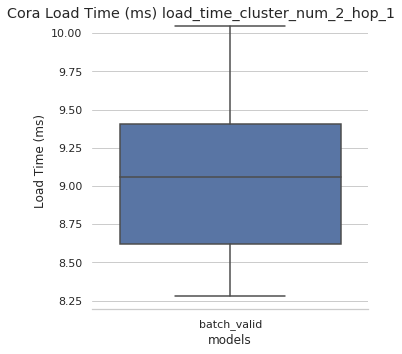

In [26]:
step0_generate_clustering_machine(data, dataset, image_data_path, intermediate_data_folder, partition_nums, layers, valid_part_num = 4)

step1_generate_train_batch(image_data_path, intermediate_data_folder, partition_nums, layers, train_frac = 0.5, \
                           batch_range = (0, 2), info_folder = './info_train_batch/', info_file = 'train_batch_size_info_{}.csv'.format('[0,2)') )

step2_generate_validation_batch(image_data_path, intermediate_data_folder, partition_nums, layers, validation_frac = 0.5, \
                                batch_range = (0, 2), info_folder = './info_validation_batch/', info_file = 'validation_batch_size_info_{}.csv'.format('[0,2)'))

step2_generate_validation_batch(image_data_path, intermediate_data_folder, partition_nums, layers, validation_frac = 0.5, \
                                batch_range = (2, 4), info_folder = './info_validation_batch/', info_file = 'validation_batch_size_info_{}.csv'.format('[2,4)'))

step3_run_train_batch(image_data_path, intermediate_data_folder, partition_nums, layers, \
                dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20)

step4_run_validation_batch(image_data_path, intermediate_data_folder, partition_nums, layers, \
                dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, valid_part_num = 4)

### PubMed dataset

In [129]:
from torch_geometric.datasets import Planetoid
data_name = 'PubMed'
dataset = Planetoid(root = local_data_root + 'Planetoid/PubMed', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name
# set the current folder as the intermediate data folder so that we can easily copy either clustering 
intermediate_data_folder = './'
partition_nums = [2, 4, 8]
layers = [[], [64], [64, 64]]

### CoraFull dataset

In [126]:
from torch_geometric.datasets import CoraFull
data_name = 'CoraFull'
dataset = CoraFull(root = local_data_root + 'CoralFull')
print('number of data: ', len(dataset))
data = dataset[0]

image_data_path = './results/' + data_name + '/' + test_folder_name
# set the current folder as the intermediate data folder so that we can easily copy either clustering 
intermediate_data_folder = './'
partition_nums = [2, 4, 8]
layers = [[], [128], [128, 128]]


number of data:  1


### Output F1

Start running for partition num: 2 hop layer 2

Start to generate the global edge weights
Edge weights creation costs a total of 0.0259 seconds!
Start to generate the clustering machine:
Batch machine creation costs a total of 0.0336 seconds!

 Information about the content of ./tmp/
File name: [ input_edge_weight_list.csv ]; with size: 267.9462890625 KB

Start to split data into train, test, validation:
Data splitting costs a total of 0.0006 seconds!
Storing batch machine after training batches generation costs a total of 0.0132 seconds!


Batch machine reading costs a total of 0.0449 seconds!
Start to generate the training batches:
*** Generate batch file for #   1 batch, writing the batch file costed 2.16 ms ***
*** Generate batch file for #   0 batch, writing the batch file costed 2.09 ms ***
Train batches production costs a total of 0.0259 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 4239.3603515625 KB
File name: [ batch_0 ]; with size: 4

*** During training for #   0 batch, reading batch file costed 1.71 ms ***
*** During training for #   0 batch, reading batch file costed 1.75 ms ***
*** During training for #   1 batch, reading batch file costed 2.05 ms ***
*** During training for #   1 batch, reading batch file costed 1.90 ms ***
*** During training for #   0 batch, reading batch file costed 1.69 ms ***
Training costs a total of 1.1723 seconds!
Start to save the GCN trainer model (parameters: weights, bias):
Storing the trainer costs a total of 0.0013 seconds!
--------------------------------------------------------------------------------

Start generate the trainer:
Trainer creation costs a total of 0.0008 seconds!
Start train the model:
*** During training for #   0 batch, reading batch file costed 1.37 ms ***
*** During training for #   1 batch, reading batch file costed 1.99 ms ***
*** During training for #   1 batch, reading batch file costed 1.38 ms ***
*** During training for #   0 batch, reading batch file c

*** During training for #   1 batch, reading batch file costed 1.49 ms ***
*** During training for #   0 batch, reading batch file costed 1.49 ms ***
*** During training for #   1 batch, reading batch file costed 1.86 ms ***
*** During training for #   1 batch, reading batch file costed 1.45 ms ***
*** During training for #   0 batch, reading batch file costed 1.42 ms ***
*** During training for #   1 batch, reading batch file costed 1.76 ms ***
*** During training for #   0 batch, reading batch file costed 1.45 ms ***
*** During training for #   0 batch, reading batch file costed 1.52 ms ***
*** During training for #   1 batch, reading batch file costed 1.39 ms ***
*** During training for #   0 batch, reading batch file costed 1.57 ms ***
*** During training for #   1 batch, reading batch file costed 1.92 ms ***
*** During training for #   1 batch, reading batch file costed 1.44 ms ***
*** During training for #   0 batch, reading batch file costed 1.68 ms ***
*** During training for #

*** During training for #   1 batch, reading batch file costed 1.57 ms ***
*** During training for #   0 batch, reading batch file costed 2.44 ms ***
*** During training for #   1 batch, reading batch file costed 1.76 ms ***
*** During training for #   0 batch, reading batch file costed 1.61 ms ***
*** During training for #   1 batch, reading batch file costed 1.65 ms ***
*** During training for #   0 batch, reading batch file costed 1.40 ms ***
*** During training for #   1 batch, reading batch file costed 1.51 ms ***
*** During training for #   0 batch, reading batch file costed 1.40 ms ***
*** During training for #   1 batch, reading batch file costed 1.70 ms ***
Training costs a total of 1.1159 seconds!
Start to save the GCN trainer model (parameters: weights, bias):
Storing the trainer costs a total of 0.0015 seconds!
--------------------------------------------------------------------------------
Start to read the GCN trainer model (parameters: weights, bias):
Reading the trainer

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

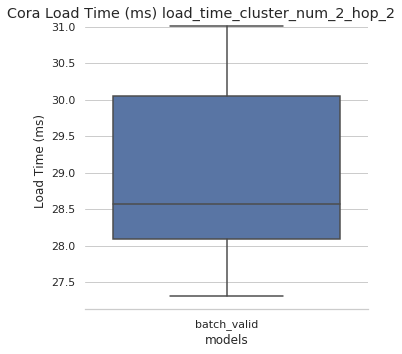

In [20]:
# check F1-score
output_F1_score(data, data_name, dataset, image_data_path, intermediate_data_folder, partition_nums, layers, \
                train_frac = 0.5, validation_frac = 0.5, valid_part_num = 2, \
                dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20)

### Tune hyper parameters

Start tuning for tuning param: batch_epoch_num partition num: 2 hop layer 1

Start to generate the global edge weights
Edge weights creation costs a total of 0.0266 seconds!
Start to generate the clustering machine:
Batch machine creation costs a total of 0.0690 seconds!

 Information about the content of ./tmp/
File name: [ input_edge_weight_list.csv ]; with size: 267.9462890625 KB

Start to split data into train, test, validation:
Data splitting costs a total of 0.0006 seconds!


Batch machine reading costs a total of 0.0105 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 2819.0869140625 KB
File name: [ batch_0 ]; with size: 3466.2744140625 KB

Batch machine reading costs a total of 0.0106 seconds!
Validation batches production costs a total of 0.0695 seconds!
Start tuning for tuning param: batch_epoch_num partition num: 2 hop layer 2

Start to generate the global edge weights
Edge weights creation costs a total of 0.0263 seconds!
Start to gene

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib

Start tuning for tuning param: batch_epoch_num partition num: 4 hop layer 1

Start to generate the global edge weights
Edge weights creation costs a total of 0.0264 seconds!
Start to generate the clustering machine:
Batch machine creation costs a total of 0.0310 seconds!

 Information about the content of ./tmp/
File name: [ input_edge_weight_list.csv ]; with size: 267.9462890625 KB

Start to split data into train, test, validation:
Data splitting costs a total of 0.0007 seconds!


Batch machine reading costs a total of 0.0070 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 2086.2197265625 KB
File name: [ batch_3 ]; with size: 1632.3759765625 KB
File name: [ batch_0 ]; with size: 1810.7900390625 KB
File name: [ batch_2 ]; with size: 1805.2431640625 KB

Batch machine reading costs a total of 0.0071 seconds!
Validation batches production costs a total of 0.0736 seconds!


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start tuning for tuning param: batch_epoch_num partition num: 4 hop layer 2

Start to generate the global edge weights
Edge weights creation costs a total of 0.0260 seconds!
Start to generate the clustering machine:
Batch machine creation costs a total of 0.0307 seconds!

 Information about the content of ./tmp/
File name: [ input_edge_weight_list.csv ]; with size: 267.9462890625 KB

Start to split data into train, test, validation:
Data splitting costs a total of 0.0007 seconds!


Batch machine reading costs a total of 0.0068 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 6598.6416015625 KB
File name: [ batch_3 ]; with size: 6112.4541015625 KB
File name: [ batch_0 ]; with size: 6564.5009765625 KB
File name: [ batch_2 ]; with size: 6613.2900390625 KB

Batch machine reading costs a total of 0.0070 seconds!
Validation batches production costs a total of 0.1229 seconds!


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start tuning for tuning param: batch_epoch_num partition num: 4 hop layer 3

Start to generate the global edge weights
Edge weights creation costs a total of 0.0266 seconds!
Start to generate the clustering machine:
Batch machine creation costs a total of 0.0315 seconds!

 Information about the content of ./tmp/
File name: [ input_edge_weight_list.csv ]; with size: 267.9462890625 KB

Start to split data into train, test, validation:
Data splitting costs a total of 0.0006 seconds!


Batch machine reading costs a total of 0.0071 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 12058.8369140625 KB
File name: [ batch_3 ]; with size: 11109.8759765625 KB
File name: [ batch_0 ]; with size: 11057.2744140625 KB
File name: [ batch_2 ]; with size: 11035.9462890625 KB

Batch machine reading costs a total of 0.0073 seconds!
Validation batches production costs a total of 0.1229 seconds!


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start tuning for tuning param: batch_epoch_num partition num: 8 hop layer 1

Start to generate the global edge weights
Edge weights creation costs a total of 0.0260 seconds!
Start to generate the clustering machine:
Batch machine creation costs a total of 0.0311 seconds!

 Information about the content of ./tmp/
File name: [ input_edge_weight_list.csv ]; with size: 267.9462890625 KB

Start to split data into train, test, validation:
Data splitting costs a total of 0.0006 seconds!


Batch machine reading costs a total of 0.0105 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 789.935546875 KB
File name: [ batch_7 ]; with size: 847.771484375 KB
File name: [ batch_3 ]; with size: 813.333984375 KB
File name: [ batch_4 ]; with size: 829.896484375 KB
File name: [ batch_6 ]; with size: 939.115234375 KB
File name: [ batch_0 ]; with size: 858.841796875 KB
File name: [ batch_5 ]; with size: 881.068359375 KB
File name: [ batch_2 ]; with size: 760.951171875 K

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start tuning for tuning param: batch_epoch_num partition num: 8 hop layer 2

Start to generate the global edge weights
Edge weights creation costs a total of 0.0265 seconds!
Start to generate the clustering machine:
Batch machine creation costs a total of 0.0320 seconds!

 Information about the content of ./tmp/
File name: [ input_edge_weight_list.csv ]; with size: 267.9462890625 KB

Start to split data into train, test, validation:
Data splitting costs a total of 0.0007 seconds!


Batch machine reading costs a total of 0.0077 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 3901.6181640625 KB
File name: [ batch_7 ]; with size: 4739.7275390625 KB
File name: [ batch_3 ]; with size: 4733.1806640625 KB
File name: [ batch_4 ]; with size: 4423.7275390625 KB
File name: [ batch_6 ]; with size: 5141.8525390625 KB
File name: [ batch_0 ]; with size: 4702.0478515625 KB
File name: [ batch_5 ]; with size: 4576.7353515625 KB
File name: [ batch_2 ]; with size: 5

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start tuning for tuning param: batch_epoch_num partition num: 8 hop layer 3

Start to generate the global edge weights
Edge weights creation costs a total of 0.0261 seconds!
Start to generate the clustering machine:
Batch machine creation costs a total of 0.0315 seconds!

 Information about the content of ./tmp/
File name: [ input_edge_weight_list.csv ]; with size: 267.9462890625 KB

Start to split data into train, test, validation:
Data splitting costs a total of 0.0006 seconds!


Batch machine reading costs a total of 0.0072 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 10277.4384765625 KB
File name: [ batch_7 ]; with size: 8562.7744140625 KB
File name: [ batch_3 ]; with size: 9139.5869140625 KB
File name: [ batch_4 ]; with size: 8998.7275390625 KB
File name: [ batch_6 ]; with size: 9074.8212890625 KB
File name: [ batch_0 ]; with size: 9070.1337890625 KB
File name: [ batch_5 ]; with size: 9334.4697265625 KB
File name: [ batch_2 ]; with size: 

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

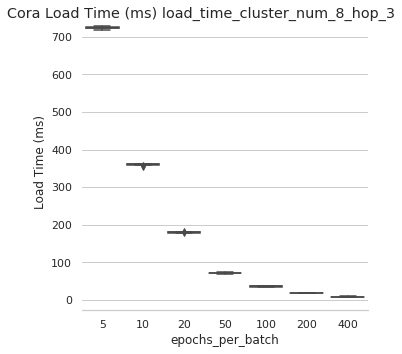

In [22]:
# tuning the mini_epoch
output_tune_param(data, data_name, dataset, image_data_path, intermediate_data_folder, partition_nums, layers, \
                  train_frac = 1.0, validation_frac = 1.0, valid_part_num = 2, \
                  dropout = 0.3, lr = 0.0001, weight_decay = 0.001, mini_epoch_num = 20)

#### Checking training loss

Start checking train loss for partition num: 2 hop layer: 1

Start to generate the global edge weights
Edge weights creation costs a total of 0.0266 seconds!
Start to generate the clustering machine:
Batch machine creation costs a total of 0.0317 seconds!

 Information about the content of ./tmp/
File name: [ input_edge_weight_list.csv ]; with size: 267.9462890625 KB

Start to split data into train, test, validation:
Data splitting costs a total of 0.0007 seconds!


Batch machine reading costs a total of 0.0087 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 3151.2744140625 KB
File name: [ batch_0 ]; with size: 2952.8369140625 KB

Batch machine reading costs a total of 0.0072 seconds!
Validation batches production costs a total of 0.1246 seconds!
Start checking train loss for partition num: 2 hop layer: 2

Start to generate the global edge weights
Edge weights creation costs a total of 0.0264 seconds!
Start to generate the clustering machine:
Bat

Validation batches production costs a total of 0.0723 seconds!
Start checking train loss for partition num: 8 hop layer: 2

Start to generate the global edge weights
Edge weights creation costs a total of 0.0258 seconds!
Start to generate the clustering machine:
Batch machine creation costs a total of 0.0304 seconds!

 Information about the content of ./tmp/
File name: [ input_edge_weight_list.csv ]; with size: 267.9462890625 KB

Start to split data into train, test, validation:
Data splitting costs a total of 0.0006 seconds!


Batch machine reading costs a total of 0.0074 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 3996.5791015625 KB
File name: [ batch_7 ]; with size: 4564.7666015625 KB
File name: [ batch_3 ]; with size: 4205.6416015625 KB
File name: [ batch_4 ]; with size: 4951.2666015625 KB
File name: [ batch_6 ]; with size: 4371.3837890625 KB
File name: [ batch_0 ]; with size: 4074.1962890625 KB
File name: [ batch_5 ]; with size: 3882.672

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

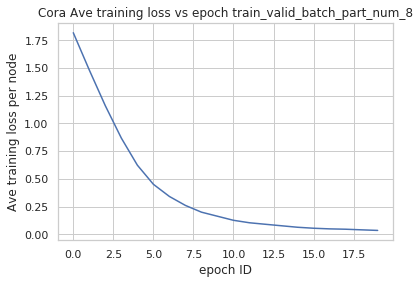

In [23]:
# check convergence
output_train_loss(data, data_name, dataset, image_data_path, intermediate_data_folder, partition_nums, layers, \
                  train_frac = 1.0, validation_frac = 1.0, valid_part_num = 2, \
                  dropout = 0.3, lr = 0.0001, weight_decay = 0.001, mini_epoch_num = 20)

### Check in_train performance

Start running for partition num: 2 hop layer 1

Start to generate the global edge weights
Edge weights creation costs a total of 0.0259 seconds!
Start to generate the clustering machine:
Batch machine creation costs a total of 0.0319 seconds!

 Information about the content of ./tmp/
File name: [ input_edge_weight_list.csv ]; with size: 267.9462890625 KB

Start to split data into train, test, validation:
Data splitting costs a total of 0.0006 seconds!


Batch machine reading costs a total of 0.0070 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 3387.8369140625 KB
File name: [ batch_0 ]; with size: 3261.2744140625 KB

Batch machine reading costs a total of 0.0073 seconds!
Validation batches production costs a total of 0.1089 seconds!
Start running for partition num: 2 hop layer 2

Start to generate the global edge weights
Edge weights creation costs a total of 0.0260 seconds!
Start to generate the clustering machine:
Batch machine creation costs 

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


Start running for partition num: 4 hop layer 3

Start to generate the global edge weights
Edge weights creation costs a total of 0.0257 seconds!
Start to generate the clustering machine:
Batch machine creation costs a total of 0.0321 seconds!

 Information about the content of ./tmp/
File name: [ input_edge_weight_list.csv ]; with size: 267.9462890625 KB

Start to split data into train, test, validation:
Data splitting costs a total of 0.0006 seconds!


Batch machine reading costs a total of 0.0070 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 11615.8291015625 KB
File name: [ batch_3 ]; with size: 11235.6181640625 KB
File name: [ batch_0 ]; with size: 11350.7900390625 KB
File name: [ batch_2 ]; with size: 11242.3134765625 KB

Batch machine reading costs a total of 0.0075 seconds!
Validation batches production costs a total of 0.1238 seconds!


/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 8 hop layer 1

Start to generate the global edge weights
Edge weights creation costs a total of 0.0255 seconds!
Start to generate the clustering machine:
Batch machine creation costs a total of 0.0313 seconds!

 Information about the content of ./tmp/
File name: [ input_edge_weight_list.csv ]; with size: 267.9462890625 KB

Start to split data into train, test, validation:
Data splitting costs a total of 0.0006 seconds!


Batch machine reading costs a total of 0.0069 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 761.302734375 KB
File name: [ batch_7 ]; with size: 852.458984375 KB
File name: [ batch_3 ]; with size: 733.021484375 KB
File name: [ batch_4 ]; with size: 761.888671875 KB
File name: [ batch_6 ]; with size: 715.091796875 KB
File name: [ batch_0 ]; with size: 807.083984375 KB
File name: [ batch_5 ]; with size: 968.099609375 KB
File name: [ batch_2 ]; with size: 801.380859375 KB

Batch machine reading cost

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 8 hop layer 2

Start to generate the global edge weights
Edge weights creation costs a total of 0.0259 seconds!
Start to generate the clustering machine:
Batch machine creation costs a total of 0.0317 seconds!

 Information about the content of ./tmp/
File name: [ input_edge_weight_list.csv ]; with size: 267.9462890625 KB

Start to split data into train, test, validation:
Data splitting costs a total of 0.0006 seconds!


Batch machine reading costs a total of 0.0070 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 5125.9931640625 KB
File name: [ batch_7 ]; with size: 4558.3994140625 KB
File name: [ batch_3 ]; with size: 4476.8916015625 KB
File name: [ batch_4 ]; with size: 3398.2197265625 KB
File name: [ batch_6 ]; with size: 4870.8369140625 KB
File name: [ batch_0 ]; with size: 4703.7275390625 KB
File name: [ batch_5 ]; with size: 4669.0009765625 KB
File name: [ batch_2 ]; with size: 4813.4541015625 KB

Batch mach

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

Start running for partition num: 8 hop layer 3

Start to generate the global edge weights
Edge weights creation costs a total of 0.0254 seconds!
Start to generate the clustering machine:
Batch machine creation costs a total of 0.0313 seconds!

 Information about the content of ./tmp/
File name: [ input_edge_weight_list.csv ]; with size: 267.9462890625 KB

Start to split data into train, test, validation:
Data splitting costs a total of 0.0006 seconds!


Batch machine reading costs a total of 0.0070 seconds!

 Information about the content of ./train/
File name: [ batch_1 ]; with size: 8920.7587890625 KB
File name: [ batch_7 ]; with size: 8177.6181640625 KB
File name: [ batch_3 ]; with size: 9564.1962890625 KB
File name: [ batch_4 ]; with size: 10036.1494140625 KB
File name: [ batch_6 ]; with size: 9069.3916015625 KB
File name: [ batch_0 ]; with size: 8165.8369140625 KB
File name: [ batch_5 ]; with size: 9927.6728515625 KB
File name: [ batch_2 ]; with size: 9814.3916015625 KB

Batch mac

/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)
/home/xiangli/anaconda3/envs/pytorch_geometric/lib/python3.7/site-packages/ipykernel_launcher.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotli

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

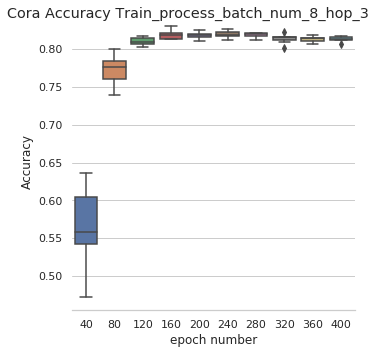

In [24]:
output_train_investigate(data, data_name, dataset, image_data_path, intermediate_data_folder, partition_nums, layers, \
                         train_frac = 1.0, validation_frac = 1.0, valid_part_num = 2, \
                         dropout = 0.3, lr = 0.0001, weight_decay = 0.001, mini_epoch_num = 20, output_period = 40)

### CiteSeer Dataset

In [ ]:
from torch_geometric.datasets import Planetoid
data_name = 'CiteSeer'
dataset = Planetoid(root = local_data_root + 'Planetoid/CiteSeer', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name

partition_nums = [2, 4, 8]
layers = [[], [16], [16, 16]]

### Appendix

In [ ]:
# free GPU memory
# !(nvidia-smi | grep 'python' | awk '{ print $3 }' | xargs -n1 kill -9)